# Decision Trees and Random Forests

So far, we've seen a simple generative classifier (naive Bayes) and a powerful discriminative classifier (support vector machines). Here we'll take a look at motivating another powerful algorithm: a non-parametric algorithm called _random forests_. Random forests are an example of an _ensemble_ method, meaning that it relies on aggregating the results of an ensemble of simpler estimators. The idea behind such ensemble methods is that the sum can be greater than the parts.

We begin, as always, with the standard imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Motivating Random Forests: Decision Trees

Random forests are an example of an _ensemble learner_ built on decision trees. For this reason we need to start by discussing decision trees themselves.

Decision trees consists in asking a series of questions in order to classify or label objects. For example, a decision tree to classify an animal might look something like this:

![Decision Tree Example](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.08-decision-tree.png)

This binary nature makes this classifier extremely efficient: in a well-constructed tree, each question will cut the number of options by roughly half. The trick comes in deciding which questions to ask at each step in order to create a well-constructed tree. In machine learning implementations of decision trees, each node generally splits the data into two groups using a cutoff value within one of the features.

### Creating a decision tree

Consider the following two-dimensional data, composed of four different classes:

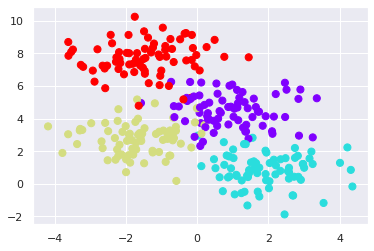

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

A decision tree will iteratively split the data along one or the other axis according to some quantitative criterion. The following figure presents a visualization of the first four levels of a decision tree classifier for this data:

![Decision Tree Classification Regions](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.08-decision-tree-levels.png)



Except for nodes that contain all samples of one color, at each level _every_ region is again split along one of the two features.

In Scikit-Learn, we can fit a decision tree to our data with the `DecisionTreeClassifier` estimator:

In [3]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

We will use the following utility function to help us visualize the classifier:

In [4]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Now we can examine what our decision tree classification looks like:

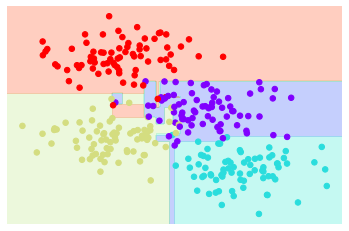

In [5]:
visualize_classifier(DecisionTreeClassifier(), X, y)

As the depth of the tree increases, we tend to get very strangely shaped classification regions, to the point where the classifier produces results biased in respect to the particular sampling or noise properties of the data, instead of the true intrinsic data distribution. Therefore, decision trees too big can lead to over-fitting.

## Ensembles of Estimators: Random Forests

The ensemble method called _bagging_ is built on top of the notion that multiple overfitting estimators can be combined to reduce the overall effect of this overfitting. Bagging makes use of an ensemble of parallel estimators, each of which over-fits the data, and average the results to find a better classification. A random forest is just such an ensemble of randomized decision trees.

In Scikit-Learn we can perform this type of bagging classification manually by using the `BaggingClassifier` meta-estimator:

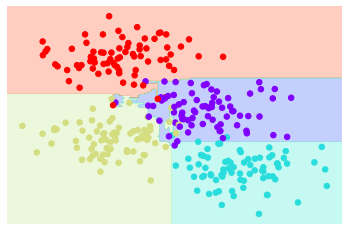

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

In this example, the data was randomized by fitting each estimator (decision tree) with a random subset of 80% of the training points. In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen. The [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest) provides more technical details about such randomization strategies.

Such an optimized ensemble of randomized decision trees is implemented in the `RandomForestClassifier` estimator. This estimator takes care of all the randomization for us, so all we need to do is select the number of estimators:

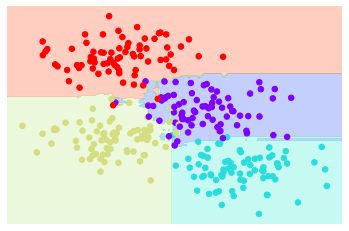

In [7]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

## Random Forest Regression

Random forests can also be used in the context of regression by using the `RandomForestRegressor` estimator. Consider the following data, drawn from the combination of a fast and a slow oscillation:

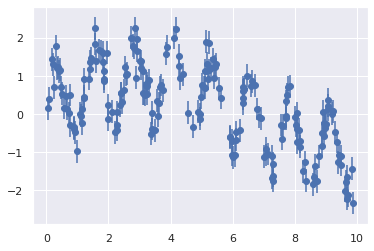

In [8]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

We can use the random forest regressor to find he best fit curve:

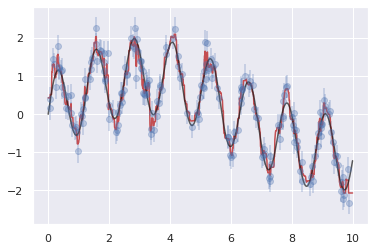

In [9]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None]) # equivalent to xfit[:, np.newaxis]
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.3)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.7);

The true model is shown in the smooth curve, while the random forest model is shown by the jagged red curve. We can see that the random forest model is flexible enough to fit the multi-period data, without the need to specify a multi-period model.

## Example: Random Forest for Classifying Digits

Let's take a look at how the random forest classifier might be used in the contest of hand-written digit classification. We'll start by taking yet another look at the digits data:

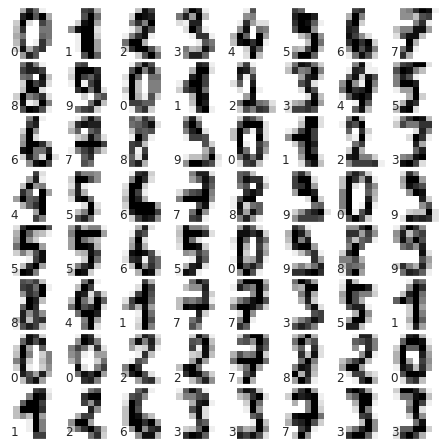

In [10]:
from sklearn.datasets import load_digits

digits = load_digits()

# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

We can classify the digit using random forest as follows:

In [11]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

Let's take a look at the classification report for this classifier:

In [12]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       1.00      0.98      0.99        44
           2       0.98      1.00      0.99        43
           3       0.98      1.00      0.99        44
           4       0.97      1.00      0.99        37
           5       0.98      0.98      0.98        48
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.96      0.98      0.97        47
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



And for good measure, plot the confusion matrix:

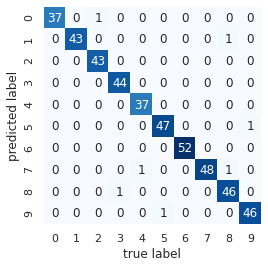

In [13]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

We can see that a simple, untuned random forest results in a very accurate classification of the digits data.